<h3 align="center">AI-Driven Car Damage Assessment & Estimate Generation</h3>

Building a car damage assessment and estimate generation follows Image → CV Model → Damage Detection + Severity → Mapping to Repair Action → CostLookup or ML Estimate → Total Estimate Generation. We will use **EfficientNetB0** model for damage assessment and **XGBRegressor** model for estimate generation. This AI-powered approach will optimize estimating precision, reduce claim processing time, and drive cost efficiency for insurers, repair facilities, and vehicle owners ensuring smarter, faster, and more reliable with auto generated claims estimates integrated within insurance workflow.

<img width=300 height=300 src="Image to Estimate Generation.jpg" />

### Import Library

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.regularizers import l2

import tensorflow as tf

### Load Data

In [2]:
data = pd.read_csv('data.csv')
data.head()

,image,classes
0,image/1.jpeg,head_lamp
1,image/2.jpeg,door_scratch
2,image/3.jpeg,head_lamp
3,image/6.jpeg,glass_shatter
4,image/8.jpeg,tail_lamp


In [3]:
if 'Unnamed: 0' in data.columns:
    data.drop(['Unnamed: 0'], inplace=True, axis=1)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1045 non-null   object
 1   classes  1045 non-null   object
dtypes: object(2)
memory usage: 16.5+ KB


In [5]:
df = data.copy()
df.head()

,image,classes
0,image/1.jpeg,head_lamp
1,image/2.jpeg,door_scratch
2,image/3.jpeg,head_lamp
3,image/6.jpeg,glass_shatter
4,image/8.jpeg,tail_lamp


### Handling Null Values

In [6]:
df_filtered = df[df["classes"] != "unknown"]

for img_path in df[df["classes"] == "unknown"]["image"]:
    if os.path.exists(img_path): 
        os.remove(img_path)

df_filtered.to_csv("data.csv", index=False)

print("Clean! Rows and images with class 'unknown' have been removed.")

Clean! Rows and images with class 'unknown' have been removed.


In [7]:
data.isnull().sum()

image      0
classes    0
dtype: int64

### Explanatory Data Analysis & Visualization

In [8]:
label_mapping = {
    'door_dent': 'Dent on the Door',
    'bumper_scratch': 'Scratches on Bumper',
    'door_scratch': 'Scratches on the Door',
    'glass_shatter': 'Broken glass',
    'tail_lamp': 'Broken Lamp',
    'head_lamp': 'Broken Lamp',
    'bumper_dent': 'Dents on Bumper'
}
df_filtered['classes'] = df_filtered['classes'].map(label_mapping)

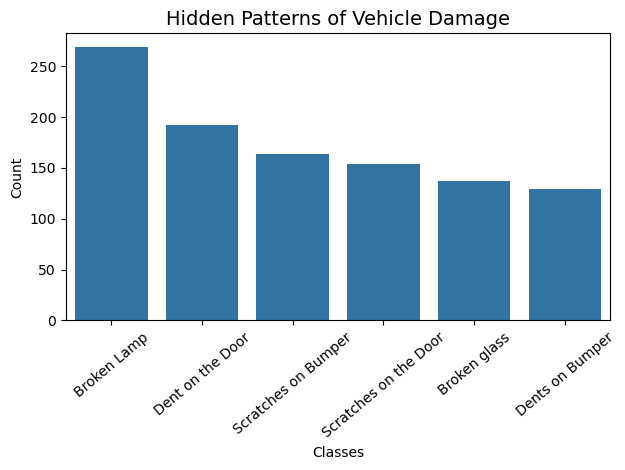

In [9]:
counts = df_filtered['classes'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=40);
plt.title('Hidden Patterns of Vehicle Damage', fontsize=14)  
plt.tight_layout() 
plt.show()

#### The Hidden Patterns of Vehicle Damage: What 1,000+ Car Incidents Reveal

*Examining our dataset of over 1,000 car damage incidents reveals a striking hierarchy of automotive vulnerabilities. At the top of our damage chart, Broken Lamps dominate with approximately 250 cases, accounting for nearly 25% of all recorded incidents. This isn't surprising—headlights and taillights protrude from the vehicle's body, making them particularly susceptible to impacts.
Following closely, Dents on the Door appear roughly 190 times, highlighting how vulnerable these large flat surfaces are to shopping carts, carelessly opened adjacent doors, and minor collisions. The middle of our damage spectrum shows Scratches on Bumpers (approximately 160 cases) and Scratches on Doors (about 150 cases)—common casualties of tight parking spaces and minor scrapes.
The least common damage types—Broken Glass (around 140 incidents) and Dents on Bumpers (about 130 cases)—still represent significant numbers. The relative rarity of broken glass suggests that modern automotive glass is effectively designed to withstand many impacts. Meanwhile, bumpers appear more likely to scratch than dent, validating their design purpose of absorbing impact.
Interestingly, the ratio between our most common damage (Broken Lamps) and least common (Dents on Bumpers) is less than 2:1, indicating a fairly balanced distribution across damage types. This suggests that automotive vulnerabilities are widespread rather than concentrated in a single failure point—valuable insight for both car manufacturers focused on design improvements and insurance companies calculating risk models.*

In [10]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1045 non-null   object
 1   classes  1045 non-null   object
dtypes: object(2)
memory usage: 16.5+ KB


In [11]:
path = 'C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset'
def edit_path_img(x):
    return path + x
    
df_filtered["image"] = df_filtered["image"].apply(edit_path_img)
df_filtered.head()

,image,classes
0,C:/Users/Lenovo/OneDrive/Documents/car_damage_...,Broken Lamp
1,C:/Users/Lenovo/OneDrive/Documents/car_damage_...,Scratches on the Door
2,C:/Users/Lenovo/OneDrive/Documents/car_damage_...,Broken Lamp
3,C:/Users/Lenovo/OneDrive/Documents/car_damage_...,Broken glass
4,C:/Users/Lenovo/OneDrive/Documents/car_damage_...,Broken Lamp


In [29]:
import os

# Check if the base directory exists
base_dir = "C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset/image"
base_exists = os.path.exists(base_dir)

# Check if image directory exists
image_dir = os.path.join(base_dir, "image")
image_exists = os.path.exists(image_dir)

# List contents of the base directory
items = os.listdir(base_dir) if base_exists else []
items_str = ", ".join(items) if items else "No items found or directory doesn't exist"

# Create a paragraph-style output
output = (
    f"The base directory exists: {base_exists}. "
    f"The image directory exists: {image_exists}. "
    f"The contents of the base directory are: {items_str}."
)

print(output)


The base directory exists: True. The image directory exists: False. The contents of the base directory are: 0.jpeg, 1.jpeg, 10.jpeg, 100.jpeg, 1000.jpeg, 1001.jpeg, 1002.jpeg, 1003.jpeg, 1004.jpeg, 1005.jpeg, 1006.jpeg, 1007.jpeg, 1008.jpeg, 1009.jpeg, 101.jpeg, 1010.jpeg, 1011.jpeg, 1012.jpeg, 1013.jpeg, 1014.jpeg, 1015.jpeg, 1016.jpeg, 1017.jpeg, 1018.jpeg, 1019.jpeg, 102.jpeg, 1020.jpeg, 1021.jpeg, 1022.jpeg, 1023.jpeg, 1024.jpeg, 1025.jpeg, 1026.jpeg, 1027.jpeg, 1028.jpeg, 1029.jpeg, 103.jpeg, 1030.jpeg, 1031.jpeg, 1032.jpeg, 1033.jpeg, 1034.jpeg, 1035.jpeg, 1036.jpeg, 1037.jpeg, 1038.jpeg, 1039.jpeg, 104.jpeg, 1040.jpeg, 1041.jpeg, 1042.jpeg, 1043.jpeg, 1044.jpeg, 1045.jpeg, 1046.jpeg, 1047.jpeg, 1048.jpeg, 1049.jpeg, 105.jpeg, 1050.jpeg, 1051.jpeg, 1052.jpeg, 1053.jpeg, 1054.jpeg, 1055.jpeg, 1056.jpeg, 1057.jpeg, 1058.jpeg, 1059.jpeg, 106.jpeg, 1060.jpeg, 1061.jpeg, 1062.jpeg, 1063.jpeg, 1064.jpeg, 1065.jpeg, 1066.jpeg, 1067.jpeg, 1068.jpeg, 1069.jpeg, 107.jpeg, 1070.jpeg, 1071.j

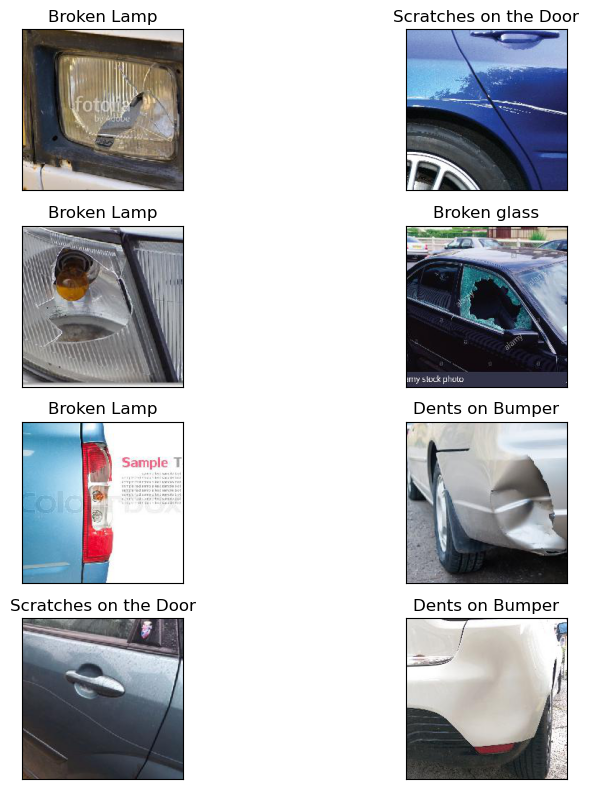

In [13]:
import os

# Update the paths in your DataFrame to point directly to the base directory
base_dir = "C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset/image"

# Extract just the filename from the current paths
df_filtered['image'] = df_filtered['image'].apply(lambda x: os.path.join(base_dir, os.path.basename(x)))

# Try again with the correct paths
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    if i < len(df_filtered): 
        try:
            ax.imshow(plt.imread(df_filtered.image[i]))
            ax.set_title(df_filtered.classes[i])
        except FileNotFoundError:
            ax.text(0.5, 0.5, f"Image not found", ha='center', va='center')
            print(f"Cannot find: {df_filtered.image[i]}")
            
plt.tight_layout()
plt.show()

### Data Preprocessing

In [14]:
train_df, test_df = train_test_split(df_filtered, test_size=0.2)

In [15]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [16]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=0
)
val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=0
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 836 validated image filenames belonging to 6 classes.
Found 836 validated image filenames belonging to 6 classes.
Found 209 validated image filenames belonging to 6 classes.


In [17]:
train_datagen_for_cnn = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [18]:
train_gen_for_cnn = train_datagen_for_cnn.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_gen_for_cnn = train_datagen_for_cnn.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=0
)

Found 836 validated image filenames belonging to 6 classes.
Found 836 validated image filenames belonging to 6 classes.


### Model Configuration

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# Custom Callback untuk menghentikan training jika acc & val_acc >= 91%
class StopAtAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        acc = logs.get("accuracy", 0)
        val_acc = logs.get("val_accuracy", 0)

        if acc >= 0.95 and val_acc >= 0.95:
            print(f"\n Accuracy dan Validation Accuracy mencapai ≥95%. Training dihentikan di epoch {epoch+1}.")
            self.model.stop_training = True

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def plot_training_history(history, model_name="Model"):
    hist_df = pd.DataFrame(history.history)

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']], ax=axs[0])
    axs[0].set_title(f'{model_name} Accuracy')
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(["Train", "Validation"])
    axs[0].grid(True)

    sns.lineplot(data=hist_df[['loss', 'val_loss']], ax=axs[1])
    axs[1].set_title(f'{model_name} Loss')
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(["Train", "Validation"])
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


def evaluate_and_visualize_results(model, test_gen, test_df, model_name="Model"):
    # Evaluasi model
    results = model.evaluate(test_gen, verbose=0)
    print(f"{model_name} Test Loss: {results[0]:.5f}")
    print(f"{model_name} Test Accuracy: {results[1] * 100:.2f}%")

    # Prediksi
    pred_probs = model.predict(test_gen)
    y_pred = np.argmax(pred_probs, axis=1)
    
    # Dapatkan label sebenarnya dan mapping
    y_true = test_gen.classes  # Gunakan label numerik dari generator
    labels = {v: k for k, v in test_gen.class_indices.items()}
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels.values(),
                yticklabels=labels.values())
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Sample predictions - PERBAIKAN UTAMA DISINI
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 9))
    fig.suptitle(f'{model_name} Sample Predictions', fontsize=14, y=1.02)
    
    for i, ax in enumerate(axes.flat):
        # Pastikan index tidak melebihi jumlah sampel
        if i < len(test_df):
            img_path = test_df.image.iloc[i]
            true_label = test_df.classes.iloc[i]
            
            # Gunakan prediksi yang sesuai
            pred_label_idx = y_pred[i]
            pred_label = labels.get(pred_label_idx, f"Unknown ({pred_label_idx})")
            
            ax.imshow(plt.imread(img_path))
            
            # Warna teks berdasarkan benar/salah
            is_correct = (true_label == list(test_gen.class_indices.keys())[pred_label_idx])
            color = 'green' if is_correct else 'red'
            
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", 
                        fontsize=10, color=color, pad=8)
            ax.axis('off')
        else:
            ax.axis('off')  # Matikan axes jika tidak ada gambar
    
    plt.tight_layout()
    plt.show()

def plot_model_comparison(histories, accuracies, model_names):
    # Prepare data
    train_acc = [max(h.history['accuracy']) for h in histories]
    val_acc = [max(h.history['val_accuracy']) for h in histories]
    
    # Create dataframe
    df = pd.DataFrame({
        "Model": model_names,
        "Training": train_acc,
        "Validation": val_acc
    }).set_index("Model")
    
    # Create figure
    plt.figure(figsize=(14, 7), dpi=100)
    
    # Set positions and width
    x = np.arange(len(model_names))
    width = 0.25
    
    # Create bars with gradient colors
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, 3))
    
    rects1 = plt.bar(x - width, df['Training'], width, 
                    label='Training', color=colors[0], edgecolor='white', linewidth=1)
    rects2 = plt.bar(x, df['Validation'], width, 
                    label='Validation', color=colors[1], edgecolor='white', linewidth=1)
    
    # Customization
    plt.title('Model Performance Comparison', fontsize=16, pad=20, fontweight='bold')
    plt.xlabel('Model Architecture', fontsize=12, labelpad=10)
    plt.ylabel('Accuracy', fontsize=12, labelpad=10)
    plt.ylim(0, 1.05)
    plt.xticks(x, model_names, fontsize=10, rotation=15, ha='right')
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            plt.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    autolabel(rects1)
    autolabel(rects2)
    
    # Legend
    plt.legend(fontsize=10, frameon=True, framealpha=1, 
              bbox_to_anchor=(1, 1), loc='upper left')
    
    # Add watermark
    plt.figtext(0.95, 0.03, 'Car Damage Assessment | Model Benchmark', 
               fontsize=10, color='gray', ha='right', va='bottom', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

In [21]:
list_comparation_test_acc = []

### Model Selection & Training

*We selected EfficientNetB0 for its unique significance trained using techniques like neural architecture search and scaling, which helps them achieve faster training and improved parameter efficiency compared to other models. This is a family of models developed by Google, known for their efficiency and high accuracy in image classification. It's designed for image classification tasks and offers a balance of efficiency, accuracy, and training speed, making it suitable for various applications.*

In [22]:
import gc
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Memory cleanup
gc.collect()
K.clear_session()

#Set your directories
train_dir = "C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset/images/train"
val_dir = "C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset/images/val"
test_dir = "C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset/images/test"
image_size = (224, 224)
batch_size = 8  # Lowered

#Image data generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class StopAtAccuracy(Callback):
    def __init__(self, target=0.95):
        super().__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= self.target:
            print(f"\nReached {self.target * 100}% validation accuracy. Stopping training.")
            self.model.stop_training = True

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model for now

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    StopAtAccuracy(target=0.95),
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)



Found 1058 images belonging to 3 classes.
Found 227 images belonging to 3 classes.
Found 227 images belonging to 3 classes.
Epoch 1/10


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 89s 516ms/step - accuracy: 0.7506 - loss: 0.7308 - val_accuracy: 0.8678 - val_loss: 0.4865 - learning_rate: 1.0000e-04
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 62s 462ms/step - accuracy: 0.8853 - loss: 0.4344 - val_accuracy: 0.8678 - val_loss: 0.4913 - learning_rate: 1.0000e-04
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 62s 465ms/step - accuracy: 0.8754 - loss: 0.4549 - val_accuracy: 0.8678 - val_loss: 0.4904 - learning_rate: 1.0000e-04
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 62s 463ms/step - accuracy: 0.8863 - loss: 0.4269 - val_accuracy: 0.8678 - val_loss: 0.4920 - learning_rate: 1.0000e-04
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 62s 463ms/step - accuracy: 0.8800 - loss: 0.4474 - val_accuracy: 0.8678 - val_loss: 0.4915 - learning_rate: 1.0000e-04
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 467ms/step - accuracy: 0.8827 - loss: 0.4325 - val_accuracy: 0.8678 - val_loss: 0.4892 - learning_rate: 1.0000e-04
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 63s 474ms/step - 

### Model Evaluation

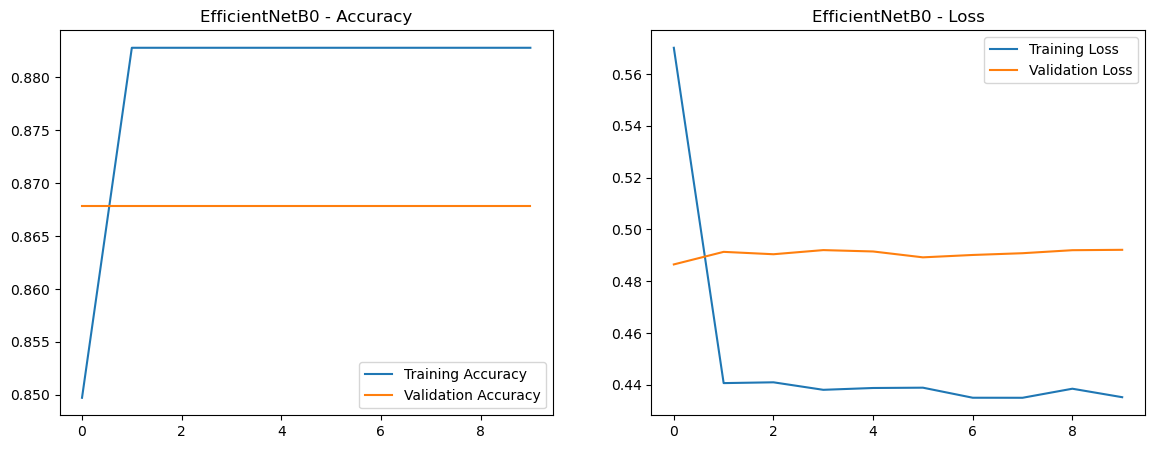

In [26]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name="EfficientNetB0"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')

    plt.show()


plot_training_history(history)



*Looking at these training graphs for EfficientNetB0, I can provide a concise analysis of the model's performance:
The accuracy graph shows the training accuracy rapidly increasing from about 0.85 to 0.883 within the first two epochs, then plateauing for the remaining epochs. Meanwhile, the validation accuracy remains nearly constant at approximately 0.868 throughout the entire training process.
On the loss graph, the training loss starts high at around 0.57 and quickly drops to about 0.44 by epoch 1, maintaining that level with minor fluctuations for the remaining epochs. The validation loss begins at roughly 0.49 and remains stable between 0.48-0.49 throughout training.
This pattern suggests classic overfitting behavior - the model performs increasingly well on training data while showing minimal improvement on validation data. The gap between training accuracy (0.883) and validation accuracy (0.868) indicates the model has memorized training data patterns that don't generalize well to new data, despite the relatively small difference of about 1.5 percentage points.*

In [25]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - accuracy: 0.6780 - loss: 0.8985
Test Accuracy: 0.8370
Test Loss: 0.5538


29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 385ms/step


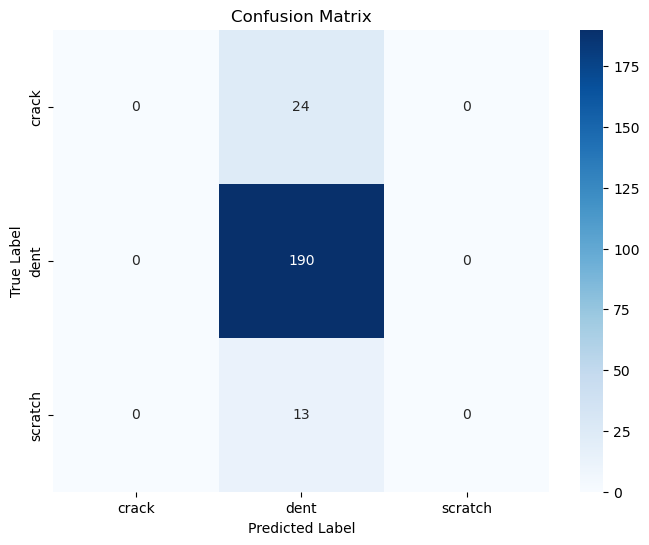

In [28]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_true = test_gen.classes

y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

class_labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


*The model appears to be heavily biased toward predicting the "dent" class for all samples. From the matrix values For true "dent" samples, the model correctly classified 190 instances, showing good sensitivity for this class with a total of 227 samples (190+24+13), the overall accuracy is approximately 83.7%*



### Sample Prediction of Damage Type

In [30]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os


In [33]:
sample_img_path = "C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset/models/201.jpeg"  

img = image.load_img(sample_img_path, target_size=image_size)
img_array = image.img_to_array(img)
img_array = img_array / 255.0 
img_array = np.expand_dims(img_array, axis=0)  


In [34]:
# Predict
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

# Get class labels
class_labels = list(test_gen.class_indices.keys())

print(f"Predicted class: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: dent


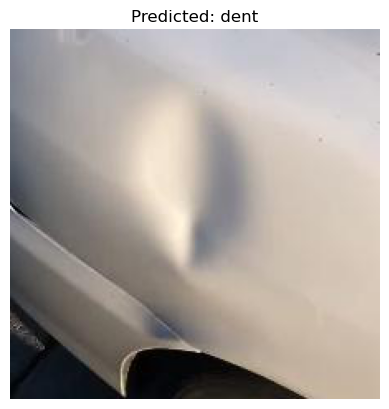

In [35]:
plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()

### Damage Severity Assessment

In [36]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

class MultiOutputDataGenerator(Sequence):
    def __init__(self, dataframe, image_dir, batch_size, image_size, damage_classes, severity_classes, shuffle=True):
        self.df = dataframe.copy()
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.damage_classes = damage_classes
        self.severity_classes = severity_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X, y_damage, y_severity = self.__data_generation(batch_df)
        return X, {'damage_output': y_damage, 'severity_output': y_severity}

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_df):
        X = np.empty((len(batch_df), *self.image_size, 3))
        y_damage = np.empty((len(batch_df), len(self.damage_classes)))
        y_severity = np.empty((len(batch_df), len(self.severity_classes)))

        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.image_dir, row['filename'])
            img = load_img(img_path, target_size=self.image_size)
            img_array = img_to_array(img) / 255.0
            X[i] = img_array

            y_damage[i] = to_categorical(self.damage_classes.index(row['damage_type']), num_classes=len(self.damage_classes))
            y_severity[i] = to_categorical(self.severity_classes.index(row['severity']), num_classes=len(self.severity_classes))

        return X, y_damage, y_severity


In [38]:
import pandas as pd

lab_df = pd.read_csv("C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset/models/labels.csv")
lab_df.head(2)

,filename,damage_type,severity
0,0.jpeg,partmissing,moderate
1,1.jpeg,crack,major


In [39]:
damage_classes = sorted(lab_df['damage_type'].unique().tolist())  
severity_classes = sorted(lab_df['severity'].unique().tolist())   


In [41]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

df = pd.read_csv("C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset/models/labels.csv")

damage_encoder = LabelEncoder()
severity_encoder = LabelEncoder()

df['damage_type_enc'] = damage_encoder.fit_transform(df['damage_type'])
df['severity_enc'] = severity_encoder.fit_transform(df['severity'])

# Save classes for reference
damage_classes = damage_encoder.classes_
severity_classes = severity_encoder.classes_


In [42]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

class MultiOutputDataGenerator(Sequence):
    def __init__(self, df, img_dir, batch_size, image_size, shuffle=True):
        self.df = df
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        batch_images = []
        batch_damage = []
        batch_severity = []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.img_dir, row['filename'])
            img = load_img(img_path, target_size=self.image_size)
            img_array = img_to_array(img) / 255.0
            batch_images.append(img_array)
            batch_damage.append(row['damage_type_enc'])
            batch_severity.append(row['severity_enc'])

        return (
            np.array(batch_images),
            {
                'damage_output': tf.keras.utils.to_categorical(batch_damage, num_classes=len(damage_classes)),
                'severity_output': tf.keras.utils.to_categorical(batch_severity, num_classes=len(severity_classes)),
            }
        )


In [46]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[['damage_type_enc', 'severity_enc']])
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df[['damage_type_enc', 'severity_enc']])

image_size = (224, 224)
batch_size = 8
img_dir = "C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset/image"

train_gen = MultiOutputDataGenerator(train_df, img_dir, batch_size, image_size)
val_gen = MultiOutputDataGenerator(val_df, img_dir, batch_size, image_size)
test_gen = MultiOutputDataGenerator(test_df, img_dir, batch_size, image_size, shuffle=False)


In [51]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

input_tensor = Input(shape=(224, 224, 3))
base = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
x = GlobalAveragePooling2D()(base.output)

# Output 1: Damage type
damage_output = Dense(len(damage_classes), activation='softmax', name='damage_output')(x)

# Output 2: Severity
severity_output = Dense(len(severity_classes), activation='softmax', name='severity_output')(x)

class StopAtAccuracy(Callback):
    def __init__(self, target=0.95, output_names=None):
        super().__init__()
        self.target = target
        self.output_names = output_names or ['damage_output', 'severity_output']
        self.metric_names = [f'val_{name}_accuracy' for name in self.output_names]

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for metric in self.metric_names:
            acc = logs.get(metric)
            print(f"Epoch {epoch+1}: {metric} = {acc}")
            if acc is not None and acc >= self.target:
                print(f"\nReached {self.target*100:.2f}% accuracy on {metric}. Stopping training.")
                self.model.stop_training = True
                break

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    StopAtAccuracy(target=0.95, output_names=('damage_output', 'severity_output')),
]

model = Model(inputs=input_tensor, outputs=[damage_output, severity_output])

model.compile(
    optimizer='adam',
    loss={'damage_output': 'categorical_crossentropy', 'severity_output': 'categorical_crossentropy'},
    metrics={'damage_output': 'accuracy', 'severity_output': 'accuracy'}
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks
)



Epoch 1/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - damage_output_accuracy: 0.6417 - damage_output_loss: 0.8584 - loss: 1.6482 - severity_output_accuracy: 0.6608 - severity_output_loss: 0.7899Epoch 1: val_damage_output_accuracy = 0.17058824002742767
Epoch 1: val_severity_output_accuracy = 0.3117647171020508
191/191 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - damage_output_accuracy: 0.6420 - damage_output_loss: 0.8578 - loss: 1.6473 - severity_output_accuracy: 0.6610 - severity_output_loss: 0.7896 - val_damage_output_accuracy: 0.1706 - val_damage_output_loss: 2.2239 - val_loss: 3.7867 - val_severity_output_accuracy: 0.3118 - val_severity_output_loss: 1.5191 - learning_rate: 0.0010
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - damage_output_accuracy: 0.8206 - damage_output_loss: 0.4663 - loss: 0.9962 - severity_output_accuracy: 0.7816 - severity_output_loss: 0.5298Epoch 2: val_damage_output_accuracy = 0.17058824002742767
Epoch 2: val_severity_output_accuracy = 0.20588235557079315
191/191

In [58]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

In [83]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

img_path = 'C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset/models/792.jpeg'

img = load_img(img_path, target_size=(224, 224))  # Use your model's input size
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

pred_damage, pred_severity = model.predict(img_array)

damage_label = damage_classes[np.argmax(pred_damage)]
severity_label = severity_classes[np.argmax(pred_severity)]

print(f"Predicted Damage Type: {damage_label}")
print(f"Predicted Severity: {severity_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Predicted Damage Type: scratch
Predicted Severity: minor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


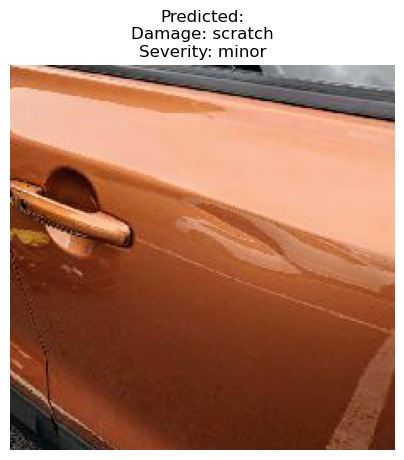

In [82]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

img_path = 'C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset/models/792.jpeg'
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0
img_batch = np.expand_dims(img_array, axis=0)

pred_damage, pred_severity = model.predict(img_batch)
damage_label = damage_classes[np.argmax(pred_damage)]
severity_label = severity_classes[np.argmax(pred_severity)]

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted:\nDamage: {damage_label}\nSeverity: {severity_label}", fontsize=12)
plt.show()


### Estimate Generation using XGBRegressor

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor


df = pd.read_csv("C:/Users/Lenovo/OneDrive/Documents/car_damage_dataset/models/cost.csv")

X = df[['severity_score', 'damage_type', 'part', 'car_model', 'region', 'part_price']]
y = df['repair_cost']

categorical_cols = ['damage_type', 'part', 'car_model', 'region']
numeric_cols = ['severity_score', 'part_price']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2


(50.215876464843745, 0.9544854389772538)

### Cost Prediction

In [86]:
import pandas as pd

sample_input = pd.DataFrame([{
    'severity_score': 3,                  
    'damage_type': 'dent',                
    'part': 'hood',                      
    'car_model': 'Honda Civic',        
    'region': 'California',              
    'part_price': 450                   
}])


In [87]:
predicted_cost = pipeline.predict(sample_input)

print(f"Estimated Repair Cost: ${predicted_cost[0]:.2f}")


Estimated Repair Cost: $603.50
